# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [36]:
# Import the tables of the data set as dataframes.
import time
start = time.time()
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt

DATA_DIR = './data' # You many change the directory

# You can use the nrows=X argument in pd.read_csv to truncate your data
users_small = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR), index_col=0)
events_small = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR), index_col=0)
subtasks_small = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)
users_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_users.csv', index_col=0)
events_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_events.csv', index_col=0)
subtasks_full = pd.read_csv(f'{DATA_DIR}/full_calcularis_subtasks.csv', index_col=0)

## Task 0: Research Question

**Research question:**
For this milestone we focus on detecting wheel-spinning behaviour of Calcularis Users. This is a time series analysis. We rely on features that were proven to be useful in various scientific papers which had to goal of detecting wheel-spinning on different datasets. Our main guide line was the paper [Towards Detecting Wheel-Spinning Future Failure in Mastery Learning](https://www.researchgate.net/publication/281716991_Towards_Detecting_Wheel-Spinning_Future_Failure_in_Mastery_Learning)

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

In [37]:
#Preprocess given data frames (clean out data)

#remove event entries which have 0 subtasks
events_cleaned = events_full[(events_full.subtasks != "[]") & ~events_full.subtasks.isna()]

#remove event/subtasks entries which have no start value, no skill_id, no correct value
subtasks_cleaned = subtasks_full[~subtasks_full.correct.isna()]
subtasks_small = subtasks_small[~subtasks_small.correct.isna()]
events_cleaned = events_cleaned[~events_cleaned.start.isna() & ~events_cleaned.skill_id.isna()]

subtasks_cleaned.drop_duplicates(inplace=True)
events_cleaned.drop_duplicates(inplace=True)

print(f"Small:: Users: {len(users_small)}, Events: {len(events_small)}, Subtasks: {len(subtasks_small)}")
print(f"Full:: Users: {len(users_full)}, Events: {len(events_full)}, Subtasks: {len(subtasks_full)}")
events_cleaned.head(1)

Small:: Users: 1000, Events: 34094, Subtasks: 55047
Full:: Users: 64932, Events: 2185200, Subtasks: 3502884


,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type
event_id,,,,,,,,,,
1,2,NORMAL,Subitizing,13094.0,"[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.0,task


In [38]:
# Your code for data processing goes here
# Select the proper dataframe (small set or full set)
events = events_cleaned
subtasks = subtasks_cleaned
# Select subtasks for which we have events
subtasks = subtasks[subtasks['event_id'].isin(events.index)]
# Create dataframe for developing features
processed_df = events.copy()
processed_df = processed_df[processed_df.type == 'task']
# Filter out irrelvant columns
processed_df = processed_df[['user_id', 'skill_id', 'learning_time_ms', 'start']]
processed_df = processed_df.reset_index()
processed_df

,event_id,user_id,skill_id,learning_time_ms,start
0,1,2,1.0,13094.0,2020-08-20T07:13:50.876Z
1,3,2,3.0,15879.0,2020-08-21T07:02:20.112Z
2,4,2,18.0,6075.0,2020-08-24T07:02:59.855Z
3,5,2,19.0,6910.0,2020-08-26T06:47:21.504Z
4,6,2,54.0,7507.0,2020-08-26T07:20:58.766Z
...,...,...,...,...,...
2152562,2399317,64997,179.0,6075.0,2020-03-24T09:12:33.561Z
2152563,2399318,64997,167.0,2621.0,2020-03-26T07:43:29.873Z
2152564,2399319,64997,178.0,68768.0,2020-03-28T08:33:44.445Z
2152565,2399320,64997,181.0,8130.0,2020-10-28T11:10:16.172Z


**Features to produce:** 
* correct response count
* correct response percentage 
* correct response in a row count
* correct response in a row percentage
* time on current skill
* skill id  
  
**Additional/Intermediary features:**
* correct
* pracitce opportunity (po)
* optimistic, pessimistic, and true labels  
  
For further description of the features please see the included report

Feature collection represented the bulk of the work for this milestone. After implementing all features, we went back through the code and improved efficiency for many features, (avoiding costly methods such as .iterrows and .apply). Many cells went from taking 1 minute on the small dataset to near instantaneous. The initial implementations are included below as comments for the sake of completeness.

**Assumptions:** the relation between subtasks and events was not clearly documented, and TA clarification didn't clear things up, so we have operated under the assumption, that each event represents a practice opportunity, with each subtask representing an attempt. We assume that subtasks are in chronological order, which we verified by manually checking timestamps. If subtasks had the same timestamp, we considered the first one.

### Correct feature  
This field is needed to aggregate both the total count and streak counts. It represents whether a user provided a correct response on their first attempt for this practice opportunity.  

In [39]:
'''
print(processed_df2.head(5))
processed_df2['correct'] = processed_df2.apply(
    lambda row: subtasks[subtasks.event_id == row.event_id].iloc[0].correct, axis=1
)
'''
first_subtask_for_event = pd.DataFrame()
first_subtask_for_event['correct'] = subtasks.groupby(['event_id']).first()['correct']
processed_df = pd.merge(first_subtask_for_event, processed_df, on='event_id', how='left')
processed_df


,event_id,correct,user_id,skill_id,learning_time_ms,start
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z
...,...,...,...,...,...,...
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z
2152563,2399318,True,64997,167.0,2621.0,2020-03-26T07:43:29.873Z
2152564,2399319,True,64997,178.0,68768.0,2020-03-28T08:33:44.445Z
2152565,2399320,False,64997,181.0,8130.0,2020-10-28T11:10:16.172Z


### PO feature
This feature represents the timestep of our time series data.

In [40]:
'''
processed_df['po'] = processed_df.apply(
    lambda row: processed_df[(processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (processed_df.start <= row.start)]['event_id'].count(),
    axis=1
)
processed_df
'''
processed_df['po'] = processed_df.groupby(['skill_id', 'user_id']).cumcount()+1
processed_df[(processed_df.user_id==64997) & (processed_df.skill_id==179)]
#processed_df


,event_id,correct,user_id,skill_id,learning_time_ms,start,po
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8


In [ ]:
plt.hist(processed_df.po)

In [41]:
# Does not include result from the current practice opportunity

processed_df['correct_response_count'] = processed_df.groupby(['user_id', 'skill_id']).correct.cumsum()
#this line is because we do not consider the current event to count towards the "correct_response_count"
#processed_df['correct_response_count'] = processed_df['correct_response_count'] - processed_df['correct']
'''processed_df['correct_response_count'] = processed_df.apply(
    lambda row: processed_df[(processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (processed_df.start < row.start)]['correct'].sum(),
    axis=1
)'''

processed_df[(processed_df.user_id==4) & (processed_df.skill_id==51)]



,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count
324,417,True,4,51.0,6684.0,2021-10-25T06:32:20.745Z,1,1
340,434,True,4,51.0,7612.0,2021-12-02T13:06:23.709Z,2,2
343,437,True,4,51.0,7552.0,2021-12-09T13:07:30.688Z,3,3
352,447,False,4,51.0,7622.0,2022-05-20T07:26:43.853Z,4,3
359,455,True,4,51.0,7356.0,2022-06-02T09:37:29.947Z,5,4
365,464,True,4,51.0,7178.0,2022-06-24T09:16:53.320Z,6,5
381,481,True,4,51.0,7388.0,2022-10-07T06:36:00.802Z,7,6


In [42]:
'''
processed_df['correct_response_percentage'] = processed_df.apply(
    lambda row: row.correct_response_count / (row.po - 1) if row.po > 1 else 0,
    axis=1
)
'''
#Again, we do not consider the current practice opportunity in the count, i.e. we devide the "PRIOR events correctly solved" by the "PRIOR events solved"
processed_df['correct_response_percentage'] = processed_df['correct_response_count'] / processed_df['po']
processed_df['correct_response_percentage'].replace(np.NaN, 0, inplace=True)

processed_df[(processed_df.user_id==64997) & (processed_df.skill_id==179)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000


In [43]:
PO_CUTOFF = 10 #TODO: move this up, so all the prior processing is faster!
before = processed_df.copy()
processed_df = processed_df[processed_df.po <= PO_CUTOFF]
print(len(before))
print(len(processed_df))
print((len(before)-len(processed_df))/len(before))
#processed_df = before[before.po <= PO_CUTOFF]

2152567
2073674
0.03665065942198315


In [44]:
processed_df = processed_df.sort_values(by=['po', 'user_id']) #TODO: sort by po AND by user_id, does this change anything?

'''
for index, row in processed_df.iterrows():
    if row.po == 1:
        processed_df.loc[index, 'correct_response_in_a_row_count'] = 0
    else:
        
        last_response = processed_df[(
            processed_df.user_id == row.user_id) & (processed_df.skill_id == row.skill_id) & (
            processed_df.po == row.po-1
        )]
        processed_df.loc[index, 'correct_response_in_a_row_count'] = last_response.correct_response_in_a_row_count.values[0] + 1 if last_response.correct.values[0] else 0
'''

mask = processed_df.correct.ne(True)
processed_df['anticorrect'] = ~processed_df['correct']
processed_df['falses_before_in_group'] = processed_df.groupby(['user_id', 'skill_id']).anticorrect.cumsum()
processed_df['correct_response_in_a_row_count'] = processed_df[~mask].groupby(['falses_before_in_group', 'user_id', 'skill_id']).cumcount().add(1)
processed_df.drop(columns=['falses_before_in_group', 'anticorrect'], inplace=True)
processed_df.fillna(0, inplace=True)

processed_df[(processed_df.user_id==64997) & (processed_df.skill_id==179)]
#processed_df.head(20)

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000,0.0
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000,0.0
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000,0.0
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000,0.0
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000,1.0
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333,2.0
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714,0.0
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000,1.0


In [45]:
'''
processed_df['correct_response_in_a_row_percentage'] = processed_df.apply(
    lambda row: row.correct_response_in_a_row_count / (row.po - 1) if row.po > 1 else 0,
    axis=1
)
'''
processed_df['correct_response_in_a_row_percentage'] = processed_df['correct_response_in_a_row_count'] / processed_df['po']
processed_df['correct_response_in_a_row_percentage'].replace(np.NaN, 0, inplace=True)


processed_df[(processed_df.user_id==64997) & (processed_df.skill_id==179)]

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage
2152530,2399282,False,64997,179.0,6720.0,2019-06-21T10:26:20.923Z,1,0,0.000000,0.0,0.000000
2152531,2399283,False,64997,179.0,7568.0,2019-07-04T12:44:54.850Z,2,0,0.000000,0.0,0.000000
2152532,2399284,False,64997,179.0,7605.0,2019-08-19T12:12:58.289Z,3,0,0.000000,0.0,0.000000
2152534,2399286,False,64997,179.0,7651.0,2019-08-27T10:50:33.716Z,4,0,0.000000,0.0,0.000000
2152549,2399301,True,64997,179.0,6085.0,2019-12-09T07:27:16.757Z,5,1,0.200000,1.0,0.200000
2152550,2399303,True,64997,179.0,6076.0,2019-12-17T14:50:26.030Z,6,2,0.333333,2.0,0.333333
2152553,2399306,False,64997,179.0,6076.0,2020-01-13T18:15:04.501Z,7,2,0.285714,0.0,0.000000
2152562,2399317,True,64997,179.0,6075.0,2020-03-24T09:12:33.561Z,8,3,0.375000,1.0,0.125000


In [46]:
'''
processed_df['time_on_current_skill_ms'] = processed_df.apply(
    lambda row: processed_df[
        (processed_df.user_id == row.user_id) &
        (processed_df.skill_id == row.skill_id) & 
        (processed_df.start <= row.start)
    ]['learning_time_ms'].sum(),
    axis=1
)
'''

time_spent = pd.DataFrame(processed_df.groupby(['user_id', 'skill_id']).learning_time_ms.cumsum())
processed_df['time_on_current_skill_ms'] = time_spent.learning_time_ms
processed_df

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z,1,0,0.0,0.0,0.0,13094.0
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z,1,1,1.0,1.0,1.0,15879.0
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z,1,1,1.0,1.0,1.0,6075.0
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z,1,1,1.0,1.0,1.0,6910.0
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z,1,1,1.0,1.0,1.0,7507.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2149794,2396170,True,64888,0.0,2116.0,2022-10-20T06:51:03.239Z,10,9,0.9,9.0,0.9,92441.0
2150114,2396531,True,64902,0.0,6063.0,2022-09-27T09:49:07.587Z,10,9,0.9,6.0,0.6,158186.0
2151260,2397811,True,64952,46.0,3788.0,2022-11-15T12:11:42.192Z,10,4,0.4,2.0,0.2,110101.0
2151272,2397825,False,64952,50.0,6098.0,2022-12-13T16:57:55.233Z,10,6,0.6,0.0,0.0,60976.0


In [47]:
'''
processed_df['pessimistic_wheelspinning'] = processed_df.apply(
    lambda row: len(processed_df[
        (processed_df.user_id == row.user_id) & 
        (processed_df.skill_id == row.skill_id) & 
        (processed_df.correct_response_in_a_row_count >= 3)
    ]) == 0,
    axis=1
)
'''
temp_df = pd.DataFrame(processed_df.groupby(['user_id', 'skill_id'])['correct_response_in_a_row_count'].max()).reset_index()
temp_df.rename(columns={'correct_response_in_a_row_count': 'max_in_a_row'}, inplace=True)
processed_df = processed_df.merge(
    temp_df, on=['user_id', 'skill_id'], how='left' 
)
processed_df['pessimistic_wheelspinning'] = processed_df.max_in_a_row < 3
processed_df.drop(columns=['max_in_a_row'])

processed_df

,event_id,correct,user_id,skill_id,learning_time_ms,start,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning
0,1,False,2,1.0,13094.0,2020-08-20T07:13:50.876Z,1,0,0.0,0.0,0.0,13094.0,0.0,True
1,3,True,2,3.0,15879.0,2020-08-21T07:02:20.112Z,1,1,1.0,1.0,1.0,15879.0,1.0,True
2,4,True,2,18.0,6075.0,2020-08-24T07:02:59.855Z,1,1,1.0,1.0,1.0,6075.0,1.0,True
3,5,True,2,19.0,6910.0,2020-08-26T06:47:21.504Z,1,1,1.0,1.0,1.0,6910.0,1.0,True
4,6,True,2,54.0,7507.0,2020-08-26T07:20:58.766Z,1,1,1.0,1.0,1.0,7507.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073669,2396170,True,64888,0.0,2116.0,2022-10-20T06:51:03.239Z,10,9,0.9,9.0,0.9,92441.0,9.0,False
2073670,2396531,True,64902,0.0,6063.0,2022-09-27T09:49:07.587Z,10,9,0.9,6.0,0.6,158186.0,6.0,False
2073671,2397811,True,64952,46.0,3788.0,2022-11-15T12:11:42.192Z,10,4,0.4,2.0,0.2,110101.0,2.0,True
2073672,2397825,False,64952,50.0,6098.0,2022-12-13T16:57:55.233Z,10,6,0.6,0.0,0.0,60976.0,3.0,False


In [48]:
users_with_sufficient_po = processed_df[processed_df.po == PO_CUTOFF].user_id.unique()
processed_df['optimistic_wheelspinning'] = processed_df.user_id.isin(users_with_sufficient_po) & processed_df.pessimistic_wheelspinning

In [49]:
processed_df.drop(columns=[
    'event_id', 'learning_time_ms', 'start', 'correct'
], inplace=True)

In [50]:
backup_df = processed_df.copy()
temp_df = processed_df[processed_df.correct_response_in_a_row_count == 3]
'''
mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min())

for index, row in processed_df.iterrows():
    if (
        ((row.user_id, row.skill_id) in mastery_achieved.index) and
        row.po >= mastery_achieved.loc[(row.user_id, row.skill_id)].po
    ):
        processed_df.drop(index=index, inplace=True)
'''

mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min()).reset_index()
mastery_achieved.rename(columns={'po': 'cutoff'}, inplace=True)
mastery_achieved.cutoff+= 1
processed_df = processed_df.merge(
    mastery_achieved, on=['user_id', 'skill_id'], how='left'
)
processed_df = processed_df[
    processed_df.cutoff.isna() |
    (processed_df.po < processed_df.cutoff)
]

processed_df.drop(columns='cutoff', inplace=True)
processed_df

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning,optimistic_wheelspinning
0,2,1.0,1,0,0.0,0.0,0.0,13094.0,0.0,True,True
1,2,3.0,1,1,1.0,1.0,1.0,15879.0,1.0,True,True
2,2,18.0,1,1,1.0,1.0,1.0,6075.0,1.0,True,True
3,2,19.0,1,1,1.0,1.0,1.0,6910.0,1.0,True,True
4,2,54.0,1,1,1.0,1.0,1.0,7507.0,1.0,True,True
...,...,...,...,...,...,...,...,...,...,...,...
2073649,64811,109.0,10,4,0.4,1.0,0.1,60796.0,2.0,True,True
2073656,64855,60.0,10,2,0.2,0.0,0.0,641130.0,1.0,True,True
2073659,64855,51.0,10,5,0.5,1.0,0.1,71520.0,2.0,True,True
2073668,64879,0.0,10,4,0.4,0.0,0.0,158299.0,2.0,True,True


In [51]:
backup_df[backup_df.user_id == 865]

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning,optimistic_wheelspinning
13537,865,1.0,1,1,1.000000,1.0,1.000000,10701.0,2.0,True,False
13538,865,29.0,1,1,1.000000,1.0,1.000000,7372.0,1.0,True,False
13539,865,4.0,1,1,1.000000,1.0,1.000000,40791.0,1.0,True,False
13540,865,12.0,1,1,1.000000,1.0,1.000000,5707.0,1.0,True,False
13541,865,19.0,1,1,1.000000,1.0,1.000000,10329.0,1.0,True,False
...,...,...,...,...,...,...,...,...,...,...,...
1907205,865,181.0,6,3,0.500000,0.0,0.000000,55344.0,2.0,True,False
1907206,865,180.0,6,6,1.000000,6.0,1.000000,40938.0,7.0,False,False
1966250,865,1.0,7,4,0.571429,1.0,0.142857,75846.0,2.0,True,False
1966251,865,169.0,7,7,1.000000,7.0,1.000000,71204.0,7.0,False,False


In [52]:
processed_df[(processed_df.user_id == 865) & (processed_df.skill_id == 48)]

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,pessimistic_wheelspinning,optimistic_wheelspinning
13543,865,48.0,1,1,1.0,1.0,1.0,7625.0,1.0,True,False


In [53]:
no_indeterminate_df = processed_df[processed_df.optimistic_wheelspinning == processed_df.pessimistic_wheelspinning]
no_indeterminate_df.rename(columns={'pessimistic_wheelspinning': 'is_wheelspinning'}, inplace=True)
no_indeterminate_df.drop(columns='optimistic_wheelspinning', inplace=True)
no_indeterminate_df

,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,max_in_a_row,is_wheelspinning
0,2,1.0,1,0,0.0,0.0,0.0,13094.0,0.0,True
1,2,3.0,1,1,1.0,1.0,1.0,15879.0,1.0,True
2,2,18.0,1,1,1.0,1.0,1.0,6075.0,1.0,True
3,2,19.0,1,1,1.0,1.0,1.0,6910.0,1.0,True
4,2,54.0,1,1,1.0,1.0,1.0,7507.0,1.0,True
...,...,...,...,...,...,...,...,...,...,...
2073649,64811,109.0,10,4,0.4,1.0,0.1,60796.0,2.0,True
2073656,64855,60.0,10,2,0.2,0.0,0.0,641130.0,1.0,True
2073659,64855,51.0,10,5,0.5,1.0,0.1,71520.0,2.0,True
2073668,64879,0.0,10,4,0.4,0.0,0.0,158299.0,2.0,True


In [54]:
#Here we determined the fraction of data we had to drop. Turned out to be around 27.5%
print(len(processed_df))
print(len(no_indeterminate_df))

len(no_indeterminate_df.groupby(['user_id', 'skill_id']).count()) / len(processed_df.groupby(['user_id', 'skill_id']).count())

1843656
753613


0.27546271167378156

In [55]:
print((no_indeterminate_df.user_id.nunique()))
print(time.time() - start)
no_indeterminate_df.drop(columns=['max_in_a_row'], inplace=True)
no_indeterminate_df[(no_indeterminate_df.user_id==2) & (no_indeterminate_df.skill_id==181)]


27758
105.13550806045532


,user_id,skill_id,po,correct_response_count,correct_response_percentage,correct_response_in_a_row_count,correct_response_in_a_row_percentage,time_on_current_skill_ms,is_wheelspinning
31,2,181.0,1,1,1.000000,1.0,1.000000,7778.0,True
1022518,2,181.0,2,1,0.500000,0.0,0.000000,15641.0,True
1451588,2,181.0,3,1,0.333333,0.0,0.000000,23525.0,True
1680889,2,181.0,4,1,0.250000,0.0,0.000000,31475.0,True
1818308,2,181.0,5,1,0.200000,0.0,0.000000,38517.0,True
1906411,2,181.0,6,2,0.333333,1.0,0.166667,46348.0,True
1965725,2,181.0,7,2,0.285714,0.0,0.000000,53699.0,True
2006847,2,181.0,8,3,0.375000,1.0,0.125000,61277.0,True
2036232,2,181.0,9,4,0.444444,2.0,0.222222,69262.0,True
2057716,2,181.0,10,4,0.400000,0.0,0.000000,77476.0,True


In [56]:
#percentage of people wheelspinning in the dataset given:
total_len = len(no_indeterminate_df)
wheelspinning_len = len(no_indeterminate_df[no_indeterminate_df.is_wheelspinning])
print(f"Percent of users which are Wheelspinning: {wheelspinning_len/total_len}")

Percent of users which are Wheelspinning: 0.38369162952337604


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

In [29]:
# Your code for training a model goes here
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
# label_df = pd.DataFrame(no_indeterminate_df.groupby(['user_id','skill_id'])['is_wheelspinning'].unique())
# label_df['is_wheelspinning'] = label_df.apply(
#     lambda row: row.is_wheelspinning[0],
#     axis=1
# )
# training_df = no_indeterminate_df.drop(columns=['is_wheelspinning'])
training_df = no_indeterminate_df.copy()
datasets = {}
models = {}
results = {}
feature_importance = {}

def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum=3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return round(accuracy, roundnum), round(auc, roundnum), conf_matrix



for po in range(2, PO_CUTOFF+1):
    dataset = training_df[no_indeterminate_df.po < po]
    users = dataset.user_id.unique()
    users_train, users_val = train_test_split(users, test_size=0.2, random_state=0)
    
    X_train = dataset[dataset.user_id.isin(users_train)]
    X_val = dataset[dataset.user_id.isin(users_val)]
    y_train = X_train.is_wheelspinning
    X_train.drop(columns='is_wheelspinning', inplace=True)
    y_val = X_val.is_wheelspinning
    X_val.drop(columns='is_wheelspinning', inplace=True)
    #print(X_train.columns)
    datasets[po] = (X_train, X_val, y_train, y_val)
    models[po] = RandomForestClassifier(
        n_estimators=50,
        max_depth=15,
        random_state=0,
        criterion='entropy'
    )
    results[po] = compute_scores(
        models[po], X_train, y_train, X_val, y_val
    )
    feature_importance[po] = models[po].feature_importances_
    print(f"Feature Importance: {feature_importance[po]}")
    print(f'For practice opportunity {po}, balanced accuracy = {results[po][0]}, AUC={results[po][1]}')
    print(results[po][2])
    #get sum of matrix:
    sum = results[po][2].sum()
    print(np.divide(results[po][2], sum))

    
    



Feature Importance: [0.08452278 0.65998728 0.         0.0314935  0.03093803 0.03812061
 0.03735425 0.11758355]
For practice opportunity 2, balanced accuracy = 0.735, AUC=0.811
[[21830  5365]
 [ 9292 18580]]
[[0.39642617 0.09742677]
 [0.1687399  0.33740716]]
Feature Importance: [0.06413896 0.46909907 0.02509792 0.11677677 0.06068753 0.09242768
 0.08323731 0.08853478]
For practice opportunity 3, balanced accuracy = 0.741, AUC=0.826
[[45708  8682]
 [14116 25287]]
[[0.48732848 0.09256554]
 [0.15050164 0.26960434]]
Feature Importance: [0.0409933  0.3011536  0.06980792 0.18287446 0.06017655 0.18390438
 0.10216028 0.0589295 ]
For practice opportunity 4, balanced accuracy = 0.762, AUC=0.872
[[71646  9939]
 [15744 28787]]
[[0.56809604 0.0788084 ]
 [0.12483745 0.22825811]]
Feature Importance: [0.04127425 0.27835337 0.05854072 0.17141719 0.06643667 0.21230615
 0.11262653 0.05904512]
For practice opportunity 5, balanced accuracy = 0.765, AUC=0.873
[[75789 10782]
 [16527 31310]]
[[0.56387269 0.0802

/var/folders/3m/bxnkpgpj2vx459g1fn11jk400000gn/T/ipykernel_16508/1341632036.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
/var/folders/3m/bxnkpgpj2vx459g1fn11jk400000gn/T/ipykernel_16508/1341632036.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)


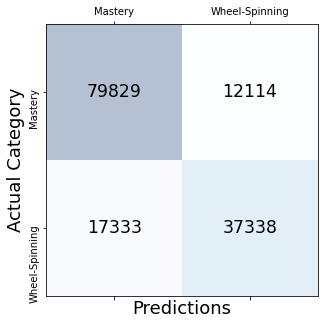

Precision: 0.7550351856345547%
Recall: 0.6829580582027035%


In [86]:
#Taking the data from the confusion matrices, we plot the precision/recall (see graphs from paper)

conf_matrices = []
conf_matrices_percent = []
for i in range(2,PO_CUTOFF+1):
    conf_matrices.append(results[i][2])
    conf_matrices_percent.append(results[i][2] / results[i][2].sum())

conf_matrix = conf_matrices[PO_CUTOFF-2]
conf_matrix_perc = conf_matrices_percent[PO_CUTOFF-2]

fig, ax = plt.subplots(figsize=(5,5))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual Category', fontsize=18)
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)

plt.show()
# From this we can compute the precision and recall:
# Precision: 
precision  = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")

/var/folders/3m/bxnkpgpj2vx459g1fn11jk400000gn/T/ipykernel_16508/597691270.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
/var/folders/3m/bxnkpgpj2vx459g1fn11jk400000gn/T/ipykernel_16508/597691270.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)


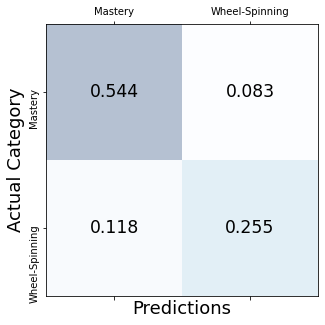

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual Category', fontsize=18)

ax.matshow(conf_matrix_perc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_perc.shape[0]):
    for j in range(conf_matrix_perc.shape[1]):
        ax.text(x=j, y=i,s=np.round(conf_matrix_perc[i, j], 3), va='center', ha='center', size='xx-large')

ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)
plt.show()

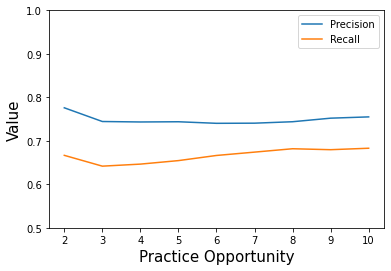

In [95]:
#plot the precision/recall across po's
precisions = []
recalls = []
for i in range(0,PO_CUTOFF-1):
    conf_matrix = conf_matrices_percent[i]
    precisions.append(conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1]))
    recalls.append(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]))


plt.plot([2,3,4,5,6,7,8,9,10], precisions)
plt.plot([2,3,4,5,6,7,8,9,10], recalls)
plt.ylim([0.5, 1])
plt.xlabel('Practice Opportunity', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(['Precision', 'Recall'])
plt.show()

    

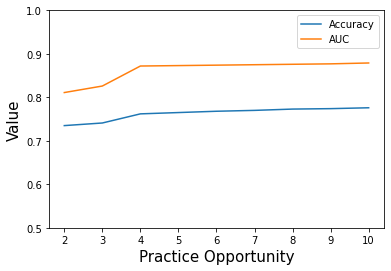

In [97]:
#plot the accuracy and the AUC
accuracy = []
auc = []
for i in range(2,PO_CUTOFF+1):
    accuracy.append(results[i][0])
    auc.append(results[i][1])

plt.plot([2,3,4,5,6,7,8,9,10],accuracy)
plt.plot([2,3,4,5,6,7,8,9,10], auc)
plt.xlabel('Practice Opportunity', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(['Accuracy', 'AUC'])
plt.ylim([0.5, 1])
plt.show()


In [24]:
import pickle
import os
import time
def save_runs(datasets, models, results, dir_name=None, cutoff=PO_CUTOFF):
    dir_name = time.time() if dir_name is None else dir_name
    os.makedirs(f'./models/{dir_name}_{cutoff}')
    for po in range(2, cutoff):
        os.makedirs(f'./models/{dir_name}_{cutoff}/datasets_{po}')
        pickle.dump(datasets[po][0], open(f'./models/{dir_name}_{cutoff}/datasets_{po}/x_train.pkl', 'wb'))
        pickle.dump(datasets[po][1], open(f'./models/{dir_name}_{cutoff}/datasets_{po}/x_val.pkl', 'wb'))
        pickle.dump(datasets[po][2], open(f'./models/{dir_name}_{cutoff}/datasets_{po}/y_train.pkl', 'wb'))
        pickle.dump(datasets[po][3], open(f'./models/{dir_name}_{cutoff}/datasets_{po}/y_val.pkl', 'wb'))
        pickle.dump(models[po], open(f'./models/{dir_name}_{cutoff}/model_{po}.pkl', 'wb'))
    pickle.dump(results, open(f'./models/{dir_name}_{cutoff}/results.pkl','wb'))

In [25]:
def finish_transform(prior, cutoff):
    new_df = prior[prior.po <= cutoff]
    new_df = new_df.sort_values(by=['po', 'user_id'])
    mask = new_df.correct.ne(True)
    new_df['anticorrect'] = ~new_df['correct']
    new_df['falses_before_in_group'] = new_df.groupby(['user_id', 'skill_id']).anticorrect.cumsum()
    new_df['correct_response_in_a_row_count'] = new_df[~mask].groupby(['falses_before_in_group', 'user_id', 'skill_id']).cumcount().add(1)
    new_df.drop(columns=['falses_before_in_group', 'anticorrect'], inplace=True)
    new_df.fillna(0, inplace=True)
    new_df['correct_response_in_a_row_percentage'] = new_df['correct_response_in_a_row_count'] / new_df['po']
    new_df['correct_response_in_a_row_percentage'].replace(np.NaN, 0, inplace=True)
    time_spent = pd.DataFrame(new_df.groupby(['user_id', 'skill_id']).learning_time_ms.cumsum())
    new_df['time_on_current_skill_ms'] = time_spent.learning_time_ms
    temp_df = pd.DataFrame(new_df.groupby(['user_id', 'skill_id'])['correct_response_in_a_row_count'].max()).reset_index()
    temp_df.rename(columns={'correct_response_in_a_row_count': 'max_in_a_row'}, inplace=True)
    new_df = new_df.merge(
        temp_df, on=['user_id', 'skill_id'], how='left' 
    )
    new_df['pessimistic_wheelspinning'] = new_df.max_in_a_row < 3
    new_df.drop(columns=['max_in_a_row'])
    users_with_sufficient_po = new_df[new_df.po == cutoff].user_id.unique()
    new_df['optimistic_wheelspinning'] = new_df.user_id.isin(users_with_sufficient_po) & new_df.pessimistic_wheelspinning
    new_df.drop(columns=[
        'event_id', 'learning_time_ms', 'start', 'correct'
        ], inplace=True)
    temp_df = new_df[new_df.correct_response_in_a_row_count == 3]
    mastery_achieved = pd.DataFrame(temp_df.groupby(['user_id', 'skill_id'])['po'].min()).reset_index()
    mastery_achieved.rename(columns={'po': 'cutoff'}, inplace=True)
    mastery_achieved.cutoff+= 1
    new_df = new_df.merge(
        mastery_achieved, on=['user_id', 'skill_id'], how='left'
    )
    new_df = new_df[
        new_df.cutoff.isna() |
        (new_df.po < new_df.cutoff)
    ]

    new_df.drop(columns='cutoff', inplace=True)
    new_df = new_df[new_df.optimistic_wheelspinning == new_df.pessimistic_wheelspinning]
    new_df.rename(columns={'pessimistic_wheelspinning': 'is_wheelspinning'}, inplace=True)
    new_df.drop(columns='optimistic_wheelspinning', inplace=True)
    new_df.drop(columns=['max_in_a_row'], inplace=True)
    return new_df  


*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [26]:
# Your code for model evaluation goes here
from sklearn.model_selection import KFold
cutoffs_to_explore = [8,10,12,14]
n_estimators_to_explore=[50,75,100,125]
depths_to_explore=[15,20,25]
criterion_to_explore=['gini', 'entropy']
K = 5
best_acc = 0
best_auc = 0
best_acc_data=None
best_auc_data=None

for cutoff in cutoffs_to_explore:
    for n_estimaors in n_estimators_to_explore:
        for depth in depths_to_explore:
            for criterion in criterion_to_explore:
                for po in range(2, cutoff+1):
                    dataset = finish_transform(before, cutoff)
                    users = dataset.user_id.unique()
                    users_train, users_val = train_test_split(users, test_size=0.2, random_state=0)
                    X_train = dataset[dataset.user_id.isin(users_train)]
                    X_val = dataset[dataset.user_id.isin(users_val)]
                    y_train = X_train.is_wheelspinning
                    X_train.drop(columns='is_wheelspinning', inplace=True)
                    y_val = X_val.is_wheelspinning
                    X_val.drop(columns='is_wheelspinning', inplace=True)
                    datasets[po] = (X_train, X_val, y_train, y_val)
                    models[po] = RandomForestClassifier(
                        n_estimators=n_estimaors,
                        max_depth=depth,
                        random_state=0,
                        criterion=criterion
                    )
                    results[po] = compute_scores(
                        models[po], X_train, y_train, X_val, y_val
                    )
                    # print(f'For practice opportunity {po}, balanced accuracy = {results[po][0]}, AUC={results[po][1]}')
                    # print(results[po][2])
                    #get sum of matrix:
                    sum = results[po][2].sum()
                    # print(np.divide(results[po][2], sum))
                if results[cutoff][0] > best_acc:
                    best_acc = results[cutoff][0]
                    best_acc_data = (datasets, models, results, f'best_acc_cu{cutoff}_n{n_estimaors}_d{depth}_cr{criterion}', cutoff)
                if results[cutoff][1] > best_auc:
                    best_auc = results[cutoff][1]
                    best_auc_data = (datasets, models, results, f'best_auc_cu{cutoff}_n{n_estimaors}_d{depth}_cr{criterion}', cutoff)

save_runs(*best_acc_data)
save_runs(*best_auc_data)
print('best acc is: ' + best_acc + '\n')
print('best auc is: ' + best_auc + '\n')

                


KeyboardInterrupt: 

In [ ]:
print(cutoff)
print(n_estimaors)
save_runs(*best_acc_data)

14
50


In [ ]:
save_runs(*best_auc_data)

In [70]:
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def compute_scores(clf, X_train, y_train, X_test, y_test, roundnum=3):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    conf_matrix = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return round(accuracy, roundnum), round(auc, roundnum), conf_matrix
# Percentage of users for validation, testing, and training
K = 3
VALDIATION_SET_SIZE = 0.1

# Set Hyperparameters
CRITERION = 'entropy'
# Tested Hyperparameters
N_ESTIMATORS_TO_EXPLORE = [50, 75, 100]
DEPTHS_TO_EXPLORE = [15, 20, 25]

RUN_DIRECTORY = './models/kfold_runs'

best_acc = 0
best_auc = 0
best_acc_hyperparameters=None
best_auc_hyperparameters=None

# os.makedirs(RUN_DIRECTORY)

dataset = training_df.copy()
users = dataset.user_id.unique()
total_training_users, validation_users = train_test_split(users, test_size=VALDIATION_SET_SIZE)

folds = KFold(n_splits=K)

for n_estimators in tqdm(N_ESTIMATORS_TO_EXPLORE):
    for depth in tqdm(DEPTHS_TO_EXPLORE):

        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=depth,
            criterion=CRITERION
        )
        run_accuracy = 0
        run_auc = 0



        for (training_users, test_users) in tqdm(folds.split(
            total_training_users
        )):
            X_train = dataset[dataset.user_id.isin(training_users)]
            X_test = dataset[dataset.user_id.isin(test_users)]
            y_train = X_train.is_wheelspinning
            y_test = X_test.is_wheelspinning

            X_train.drop(columns=['is_wheelspinning', 'user_id'], inplace=True)
            X_test.drop(columns=['is_wheelspinning', 'user_id'], inplace=True)

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)

            accuracy = balanced_accuracy_score(y_test, y_pred)
            y_pred_proba = model.predict_proba(X_test)[:,1]
            auc = roc_auc_score(y_test, y_pred_proba)

            run_accuracy+= accuracy/K
            run_auc += auc/K
        
        if run_auc > best_auc:
            best_auc = run_auc
            best_auc_hyperparameters = (n_estimators, depth)
        if run_accuracy > best_acc:
            best_acc = run_accuracy
            best_acc_hyperparameters = (n_estimators, depth)

X_train = dataset[dataset.user_id.isin(total_training_users)]
X_val = dataset[dataset.user_id.isin(validation_users)]
y_train = X_train.is_wheelspinning
y_val = X_val.is_wheelspinning

X_train.drop(columns=['is_wheelspinning', 'user_id'], inplace=True)
X_val.drop(columns=['is_wheelspinning', 'user_id'], inplace=True)


acc_model = RandomForestClassifier(
    n_estimators=best_acc_hyperparameters[0],
    max_depth=best_acc_hyperparameters[1],
    criterion=CRITERION
)
auc_model = RandomForestClassifier(
    n_estimators=best_auc_hyperparameters[0],
    max_depth=best_auc_hyperparameters[1],
    criterion=CRITERION
)
acc_results = compute_scores(
   acc_model, X_train, y_train, X_val, y_val 
)
accuracy, auc, _ = acc_results
print('===={Best Accuracy Model}====\n')
print(f'Hyperparameters: {best_acc_hyperparameters[0]} estimators, {best_acc_hyperparameters[1]} maximum tree depth')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {auc}')

auc_results = compute_scores(
    auc_model, X_train, y_train, X_val, y_val 
)
accuracy, auc, _ = auc_results
print('===={Best AUC Model}====\n')
print(f'Hyperparameters: {best_auc_hyperparameters[0]} estimators, {best_auc_hyperparameters[1]} maximum tree depth')
print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {auc}')


            

        
        









  0%|          | 0/3 [00:00<?, ?it/s]



3it [00:26,  8.94s/it]




3it [00:34, 11.39s/it]




3it [00:38, 12.90s/it]
 33%|███▎      | 1/3 [01:39<03:19, 99.74s/it]



3it [00:42, 14.05s/it]




3it [00:51, 17.32s/it]




3it [01:01, 20.35s/it]
 67%|██████▋   | 2/3 [04:14<02:12, 132.36s/it]



3it [00:55, 18.51s/it]




3it [01:09, 23.27s/it]




3it [01:20, 26.92s/it]
100%|██████████| 3/3 [07:41<00:00, 153.69s/it]


===={Best Accuracy Model}====

Hyperparameters: 100 estimators, 15 maximum tree depth
Accuracy: 0.784
ROC AUC: 0.886
===={Best AUC Model}====

Hyperparameters: 100 estimators, 15 maximum tree depth
Accuracy: 0.785
ROC AUC: 0.886


C:\Users\decla\AppData\Local\Temp\ipykernel_30352\2872730725.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
C:\Users\decla\AppData\Local\Temp\ipykernel_30352\2872730725.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)


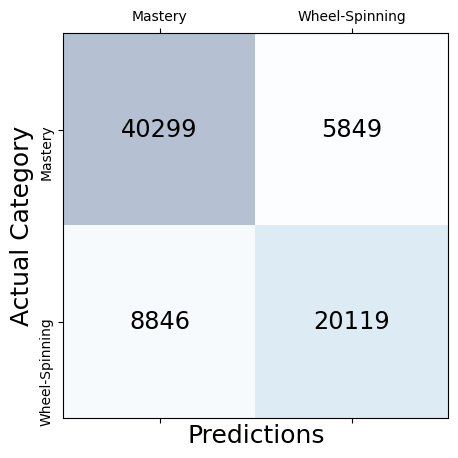

Precision: 0.7747612446087492%
Recall: 0.6945969273260832%


In [71]:
conf_matrix = acc_results[2]
conf_matrix_perc = conf_matrix / conf_matrix.sum()

fig, ax = plt.subplots(figsize=(5,5))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual Category', fontsize=18)
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)

plt.show()
# From this we can compute the precision and recall:
# Precision: 
precision  = conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])
recall = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
print(f"Precision: {precision}%")
print(f"Recall: {recall}%")

C:\Users\decla\AppData\Local\Temp\ipykernel_30352\597691270.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
C:\Users\decla\AppData\Local\Temp\ipykernel_30352\597691270.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)


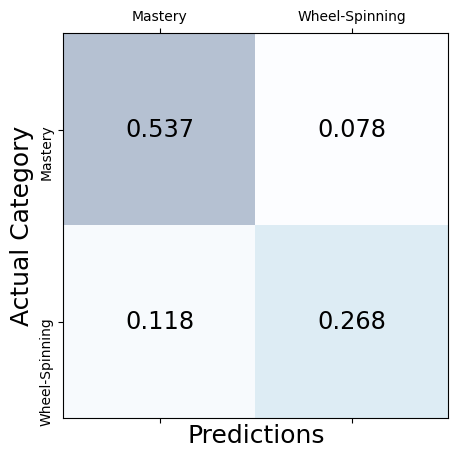

In [72]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual Category', fontsize=18)

ax.matshow(conf_matrix_perc, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix_perc.shape[0]):
    for j in range(conf_matrix_perc.shape[1]):
        ax.text(x=j, y=i,s=np.round(conf_matrix_perc[i, j], 3), va='center', ha='center', size='xx-large')

ax.set_xticklabels(['']+['Mastery', 'Wheel-Spinning'])
ax.set_yticklabels(['']+['Mastery', 'Wheel-Spinning'], rotation=90)
plt.show()

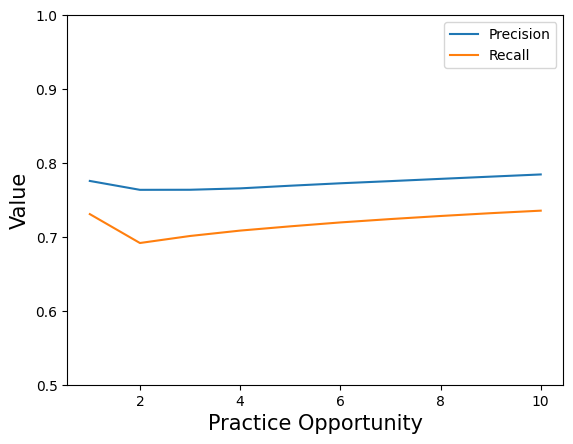

In [76]:
precisions = []
recalls = []
conf_matrices = []
accuracies = []
aucs = []
best_model = RandomForestClassifier(
    n_estimators=best_acc_hyperparameters[0],
    max_depth=best_acc_hyperparameters[1],
    criterion=CRITERION
)
best_model.fit(X_train, y_train)
for i in range(1, PO_CUTOFF + 1):
    limited_validation = dataset[dataset.user_id.isin(validation_users)]
    limited_validation = limited_validation[limited_validation.po <= i]
    y_lim_val =limited_validation.is_wheelspinning
    X_lim_val = limited_validation.drop(columns=['user_id', 'is_wheelspinning'])
    y_pred = model.predict(X_lim_val)
    accuracy = balanced_accuracy_score(y_lim_val, y_pred)

    y_pred_proba = model.predict_proba(X_lim_val)[:,1]
    conf_matrix = confusion_matrix(y_lim_val, y_pred)
    auc = roc_auc_score(y_lim_val, y_pred_proba)
    
    accuracies.append(accuracy)
    aucs.append(auc)
    conf_matrices.append(conf_matrix)
    precisions.append(conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1]))
    recalls.append(conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1]))

plt.plot([1,2,3,4,5,6,7,8,9,10], precisions)
plt.plot([1,2,3,4,5,6,7,8,9,10], recalls)
plt.ylim([0.5, 1])
plt.xlabel('Practice Opportunity', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(['Precision', 'Recall'])
plt.show()



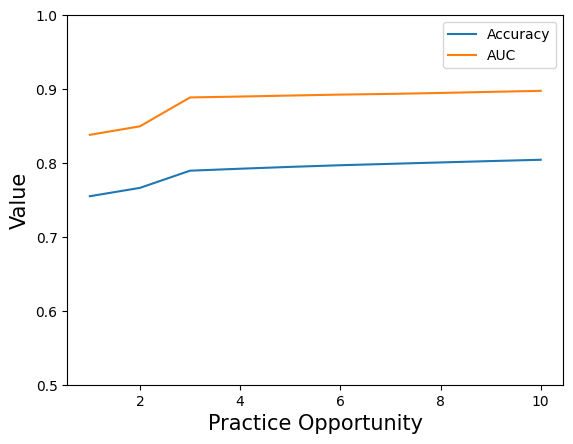

In [77]:
plt.plot([1,2,3,4,5,6,7,8,9,10],accuracies)
plt.plot([1, 2,3,4,5,6,7,8,9,10], aucs)
plt.xlabel('Practice Opportunity', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.legend(['Accuracy', 'AUC'])
plt.ylim([0.5, 1])
plt.show()

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*